## Extract features for sepsis patients received propofol (induction). Some tables are obtained by running the official GitHub repo.

In [1]:
#libraries
import numpy as np
import pandas as pd
import psycopg2 #used to connect to our local MIMIC-III database
import collections
# import getpass
from datetime import datetime
import os,sys,re
import pickle
import csv
import math
#import seaborn as sns
# import random
from datetime import timedelta
from pathlib import Path
import importlib
import bisect
import glob
import copy


from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
        'width': 1024,
        'height': 768,
        'scroll': True,
})

#%load_ext autotime

{'width': 1024, 'height': 768, 'scroll': True}

In [2]:
dbname = 'mimiciii'
password = '15289943821'
user = 'postgres'
conn = psycopg2.connect(dbname=dbname, password=password,user=user)
cur=conn.cursor()

### Select sepsis cohort

In [3]:
query_sepsis = """
select ss.icustay_id, ss.hadm_id, ss.age, ss.is_male, ss.race_white, ss.race_black, ss.race_hispanic,
ss.race_other,  mv.weight
from public.sepsis3 ss join (select DISTINCT mv.icustay_id, mv.patientweight as weight from public.inputevents_mv mv where 
 mv.itemid = 222168 and mv.ordercategorydescription = 'Drug Push') mv on ss.icustay_id = 
mv.icustay_id where 
"""
features = ['ss.age', 'ss.is_male', 'ss.race_white', 'ss.race_black', 'ss.race_hispanic','ss.race_hispanic', 
            'ss.race_other', 'mv.weight']

for i in features:
    query_sepsis +=  i + ' is not null and '
query_sepsis = query_sepsis[:-len(' and ')]

    
query_pivoted_lab = '''
select * from public.pivoted_lab where icustay_id is not null
'''

sql_statement = '''
select * from (
with ss as (
'''\
+ query_sepsis + ' ),  pvl as (' \
+ query_pivoted_lab + ') '\
+'''
select pvl.subject_id as subject_id, ss.icustay_id as icustay_id, ss.hadm_id as hadm_id,
ss.age as age, ss.is_male as is_male, ss.race_white as race_white, ss.race_black as race_black, ss.race_hispanic 
as race_hispanic, ss.race_other as race_other, ss.weight as weight, 
pvl.charttime as pvl_charttime, pvl.aniongap as aniongap, pvl.albumin as albumin, pvl.bands as bands,
pvl.bicarbonate as bicarbonate, pvl.bilirubin as bilirubin, pvl.creatinine as creatinine,pvl.chloride as chloride,
pvl.hematocrit as hematocrit,pvl.hemoglobin as hemoglobin,pvl.lactate as lactate,
pvl.platelet as platelet,pvl.potassium as potassium,pvl.ptt as ptt,pvl.inr as inr,pvl.pt as pt,
pvl.sodium as sodium,pvl.bun as bun,pvl.wbc as wbc 
from ss join  pvl on ss.hadm_id=pvl.hadm_id
) cohort where cohort.icustay_id in (select icustay_id from public.inputevents_mv where itemid = 222168 and 
ordercategorydescription = 'Drug Push')

''' 



ppt_df = pd.read_sql_query(sql_statement,conn) 
ppt_df

,subject_id,icustay_id,hadm_id,age,is_male,race_white,race_black,race_hispanic,race_other,weight,...,hemoglobin,lactate,platelet,potassium,ptt,inr,pt,sodium,bun,wbc
0,87977,214619,100011,21.5036,1,0,0,1,0,74.1,...,NaN,NaN,NaN,4.0,NaN,NaN,NaN,138.0,NaN,NaN
1,87977,214619,100011,21.5036,1,0,0,1,0,74.1,...,15.2,NaN,314.0,NaN,26.0,1.4,16.2,NaN,12.0,17.7
2,87977,214619,100011,21.5036,1,0,0,1,0,74.1,...,NaN,3.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,87977,214619,100011,21.5036,1,0,0,1,0,74.1,...,13.2,NaN,295.0,4.1,25.9,1.4,15.8,141.0,12.0,17.3
4,87977,214619,100011,21.5036,1,0,0,1,0,74.1,...,NaN,2.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92961,53283,299949,199962,22.9327,1,1,0,0,0,79.0,...,NaN,4.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
92962,53283,299949,199962,22.9327,1,1,0,0,0,79.0,...,10.9,NaN,210.0,NaN,27.5,1.3,14.5,NaN,NaN,22.5
92963,53283,299949,199962,22.9327,1,1,0,0,0,79.0,...,NaN,2.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
92964,53283,299949,199962,22.9327,1,1,0,0,0,79.0,...,NaN,2.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
def median_impute(df, columns):
    # df has column icustay_id
    for col in columns:
        median = df[col].dropna(how='any').median() # global median
        stay_median = {}
        for stay,val in zip(df['icustay_id'], df[col]):
            if stay not in stay_median:
                stay_median[stay] = []
            if not math.isnan(float(val)):
                stay_median[stay].append(float(val))
        stay_median1 = {}
        for i in stay_median:
            vals = stay_median[i]
            if len(vals) == 0:
                stay_median1[i] = median # global median
            else:
                stay_median1[i] = np.median(vals) # local median
        new_values = []
        for stay,val in zip(df['icustay_id'], df[col]):
            if math.isnan(float(val)):
                new_values.append(stay_median1[stay])
            else:
                new_values.append(float(val))
        df[col] = new_values
    return df

def datetime_to_sec(df,time_col='charttime'):
    time_in_sec = []
    date_format = '%Y-%m-%d %H:%M:%S'
    for i in df[time_col]:
        time_in_sec.append(datetime.strptime(str(i),date_format).timestamp())
    df[time_col] = time_in_sec
    return df

def datetime_to_sec_entry(time):
    date_format = '%Y-%m-%d %H:%M:%S'
    return datetime.strptime(str(time),date_format).timestamp()

In [7]:
ppt_df = datetime_to_sec(ppt_df, time_col='pvl_charttime')
columns = ['aniongap', 'albumin','bands','bicarbonate','bilirubin','creatinine','chloride', 'hematocrit',\
          'hemoglobin', 'lactate', 'platelet', 'potassium', 'ptt', 'inr', 'pt', 'sodium', 'bun', 'wbc'] # drop glucose
ppt_df = median_impute(ppt_df, columns)
ppt_df

,subject_id,icustay_id,hadm_id,age,is_male,race_white,race_black,race_hispanic,race_other,weight,...,hemoglobin,lactate,platelet,potassium,ptt,inr,pt,sodium,bun,wbc
0,87977,214619,100011,21.5036,1,0,0,1,0,74.1,...,9.3,3.05,304.0,4.0,27.05,1.4,15.95,138.0,12.0,9.60
1,87977,214619,100011,21.5036,1,0,0,1,0,74.1,...,15.2,3.05,314.0,4.0,26.00,1.4,16.20,138.0,12.0,17.70
2,87977,214619,100011,21.5036,1,0,0,1,0,74.1,...,9.3,3.80,304.0,4.0,27.05,1.4,15.95,138.0,12.0,9.60
3,87977,214619,100011,21.5036,1,0,0,1,0,74.1,...,13.2,3.05,295.0,4.1,25.90,1.4,15.80,141.0,12.0,17.30
4,87977,214619,100011,21.5036,1,0,0,1,0,74.1,...,9.3,2.30,304.0,4.0,27.05,1.4,15.95,138.0,12.0,9.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92961,53283,299949,199962,22.9327,1,1,0,0,0,79.0,...,9.9,4.70,259.0,3.7,24.65,1.2,14.00,142.0,10.5,20.95
92962,53283,299949,199962,22.9327,1,1,0,0,0,79.0,...,10.9,3.55,210.0,3.7,27.50,1.3,14.50,142.0,10.5,22.50
92963,53283,299949,199962,22.9327,1,1,0,0,0,79.0,...,9.9,2.80,259.0,3.7,24.65,1.2,14.00,142.0,10.5,20.95
92964,53283,299949,199962,22.9327,1,1,0,0,0,79.0,...,9.9,2.60,259.0,3.7,24.65,1.2,14.00,142.0,10.5,20.95


### Extract vital signs and impute

In [9]:
def feature_dict(df, feature_start=2, stay=0, time=1):
    result = {}
    n = len(df)
    for i in range(n):
        row = list(df.iloc[i])
        stay_id = row[stay]
        charttime = row[time]
        features = row[feature_start:]
        if stay_id not in result:
            result[stay_id] = {}
        result[stay_id][charttime] = features
    return result 

file = './vital_df.pickle'
if os.path.exists(file):
    file = open(file,'rb')
    vital_dict = pickle.load(file) # {'icustay_id:{charttime1:[features], charttime2:[features]}'}
else:    
    stay_id = []
    for i in ppt_df['icustay_id']:
        stay_id.append(int(i))


    query_vital = 'select * from public.pivoted_vital where icustay_id in (select icustay_id from public.sepsis3)'
    vital_df = pd.read_sql_query(query_vital,conn) 
    exclude = []
    row = 0
    for i in vital_df['icustay_id']:
        if int(i) not in stay_id:
            exclude.append(row)
        row += 1
    vital_df.drop(exclude) # [icustay_id, charttime, 'heartrate', 'sysbp','diasbp','meanbp','resprate','tempc','spo2','glucose']
    columns = ['heartrate', 'sysbp','diasbp','meanbp','resprate','tempc','spo2','glucose']
    vital_df = median_impute(vital_df,columns)
    vital_df = datetime_to_sec(vital_df)
    vital_dict = vital_df = feature_dict(vital_df, feature_start=2) # {'icustay_id:{charttime1:[features], charttime2:[features]}'}
    file = open(file,"wb")
    pickle.dump(vital_dict, file)

### Convert lab DF into dictionary

In [11]:
stay_start = {}
for i,j in zip(ppt_df['icustay_id'], ppt_df['pvl_charttime']):
    if i not in stay_start:
        stay_start[i] = []
    stay_start[i].append(j)
for i in stay_start:
    stay_start[i] = min(stay_start[i])

columns = ['subject_id','icustay_id', 'hadm_id', 'pvl_charttime','age', 'is_male', 'race_white', 'race_black', \
           'race_hispanic', 'race_other',  'weight', \
           'aniongap', 'albumin','bands','bicarbonate','bilirubin','creatinine',\
           'chloride', 'hematocrit','hemoglobin', 'lactate', 'platelet', 'potassium', 'ptt', 'inr', 'pt', \
           'sodium', 'bun', 'wbc']
ppt_dict = ppt_df = feature_dict(ppt_df[columns], feature_start=4, stay=1, time=3) # [subject_id, icustay_id, hadm_id,...]
# {'icustay_id:{charttime1:[features], charttime2:[features]}'}

## Merge lab and vital signs

In [19]:
structural_features= {} # {'icustay_id:{charttime1:[features], charttime2:[features]}'}
for stay in stay_start:
    start = stay_start[stay]
    lab_times = sorted(ppt_dict[stay].keys())
    temp = {}
    for vital_time in vital_dict[stay]:
        idx = bisect.bisect_left(lab_times, vital_time) - 1
        if idx < 0:
            continue
        lab_time = lab_times[idx]
        merged_features = copy.deepcopy(ppt_dict[stay][lab_time])
        merged_features.extend(vital_dict[stay][vital_time])
        temp[vital_time] = merged_features
    if len(temp) == 0:
        continue
    else:
        structural_features[stay] = temp

#del ppt_dict
#del vital_dict

## Extract treatment

In [21]:
file = './treatment.pickle'
if os.path.exists(file): #os.path.exists(file)
    file = open(file,'rb')
    treatment_dict = pickle.load(file) #  {icustay_id:{time1:dosage1, time2:dosage2}}
else:
    treatment_query = '''
    select icustay_id, starttime, (amount / patientweight) as dosage_mg_kg 
    from public.inputevents_mv where itemid=222168 and ordercategorydescription = 'Drug Push' 
    '''
    treatment_df = pd.read_sql_query(treatment_query,conn)
    treatment_dict = {}
    n = len(treatment_df)
    for i in range(n):
        icustay_id, time, amount = list(treatment_df[['icustay_id', 'starttime', 'dosage_mg_kg']].iloc[i])
        if icustay_id not in stay_start:
            continue
        else:
            if icustay_id not in treatment_dict:
                treatment_dict[icustay_id] = {}
            treatment_dict[icustay_id][datetime_to_sec_entry(time)] = amount
    del treatment_df
    file = open(file,"wb")
    pickle.dump(treatment_dict, file)

## Extract outcome

In [23]:
file = './outocmes.pickle'
if os.path.exists(file): #os.path.exists(file)
    file = open(file,'rb')
    outcome_dict = pickle.load(file) #  {icustay_id:{time1:SAS1, time2:SAS2}}
else:
    outcome_query = '''
    select icustay_id, charttime, valuenum from public.chartevents where itemid = 223753 and 
    icustay_id in (select icustay_id from public.inputevents_mv where itemid=222168 and ordercategorydescription = 'Drug Push')
    '''
    outcome_df = pd.read_sql_query(outcome_query,conn)
    outcome_dict = {}
    n = len(outcome_df)
    for i in range(n):
        icustay_id, time, ss = list(outcome_df[['icustay_id', 'charttime', 'valuenum']].iloc[i])
        if icustay_id not in stay_start:
            continue
        else:
            if icustay_id not in outcome_dict:
                outcome_dict[icustay_id] = {}
            outcome_dict[icustay_id][datetime_to_sec_entry(time)] = ss
    file = open(file,"wb")
    pickle.dump(outcome_dict, file)
    del outcome_df
    

## Merge features, dosage, outcome

In [33]:
## structural_features= {}  {'icustay_id:{charttime1:[features], charttime2:[features]}'}
## treatment_dict = {} {icustay_id:{time1:dosage1, time2:dosage2}}
## outcome_dict = {} {icustay_id:{time1:SAS1, time2:SAS2}}
## stay_start {icustay_id: starttime}

## incusion criteria: non_sedated prior to treatment, receive profol drug push. The label must be recorded
## within some time after treatment. Sepsis cohort.

unique_stay = set()
all_data = []
maxtime_after_treatment = 1800 # sec, the maximum time after treatment that the label should be recorded

for stay in treatment_dict:
    if stay not in structural_features or stay not in outcome_dict:
        continue
    for treat_start in treatment_dict[stay]:
        temp = []
        # find features before treatment
        feature_times = sorted(list(structural_features[stay]))
        idx = bisect.bisect_left(feature_times, treat_start) - 1
        if idx < 0:
            continue
        features = structural_features[stay][feature_times[idx]]
        # find dosage
        dosage = treatment_dict[stay][treat_start]
        
        label_times = sorted(list(outcome_dict[stay]))
        idx = bisect.bisect_left(label_times, treat_start) - 1
        if idx < 0: 
            continue
        label_before_t = outcome_dict[stay][label_times[idx]] # label before treatment
        
        if label_before_t <= 3:
            continue # patient is sedated
        try:
            label_time = label_times[idx + 1]
        except:
            continue # no label
        # check if label is recorded too late
        if label_time - treat_start > maxtime_after_treatment:
            continue
        label_after_t = outcome_dict[stay][label_time]
        temp.append(label_after_t)
        temp.append(dosage)
        temp.extend(features)
        temp.append(label_before_t)
        all_data.append(temp)
        unique_stay.add(stay)

In [34]:
len(all_data)

230

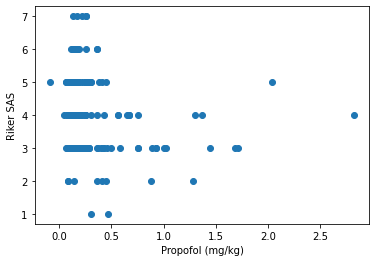

In [28]:
import matplotlib.pyplot as plt
plt.scatter(np.array(all_data)[:,1],np.array(all_data)[:,0])
plt.xlabel('Propofol (mg/kg)')
plt.ylabel('Riker SAS')
plt.show()

### Store data

In [35]:
for i in [structural_features, treatment_dict, outcome_dict, stay_start]:
    del i
def write_csv(outpath, data):
    with open(outpath, 'w',newline='') as file:
        writer = csv.writer(file, delimiter=',')
        writer.writerows(data)
file = './mimiciii_seda_raw.csv'
write_csv(file, all_data)

### Find unique patient

In [38]:
sepsis_query = '''
select icu.subject_id, ss.icustay_id from public.sepsis3 ss join public.icustays icu on 
ss.icustay_id=icu.icustay_id
'''
sepsis_df = pd.read_sql_query(sepsis_query,conn)
sepsis_dict = {} # {icustay_id:subject_id}
n = len(sepsis_df)
for i in range(n):
    subject, stay = list(sepsis_df[['subject_id', 'icustay_id']].iloc[i])
    if stay not in sepsis_dict:
        sepsis_dict[stay] = []
    sepsis_dict[stay].append(subject)
    
unique_subject = set()
for i in unique_stay:
    for j in sepsis_dict[i]:
        unique_subject.add(j)
print(('The number of unique subject: ', len(unique_subject)))

('The number of unique subject: ', 112)
